#### Business understanding

Door ProRail zijn wij benaderd om een oplossing te bieden voor het voorspellen van de reparatietijd van problemen op het spoor. ProRail is verantwoordelijk voor het spoorwegnet van Nederland. ProRail heeft een eigen DataLab dat op basis van data van ProRail, de NS en andere partijen oplossingen realiseert. De doelstelling van dit project is om met deze data de planners van de NS te helpen om de hervatting van het treinverkeer te organiseren. Hierbij beantwoorden wij de vraag of op basis van de data een betere voorspelling kan worden gemaakt, zodat de dienstregeling sneller hervat kan worden. Wij hebben hier drie weken de tijd voor gekregen om de relevante bedrijfsprocessen in kaart te brengen, een gewenste situatie te discussiëren met de product owner, een gebruikersapplicatie te bouwen en één of meer nuttige modellen te maken. Op basis van ons onderzoek zullen wij advies doen aan ProRail, over wat zij kan doen om de gewenste situatie te realiseren.

Onderzoeksvragen:
    -Kan er een voorspelling worden gedaan over de reparatietijd om efficiënter de treinplanning te hervatten?
    -Hoe accuraat zijn de prognoses over de reparatietijd van de aannemers?

### Data Understanding
Van ProRail hebben we een [data dictionary](https://canvas.hu.nl/courses/27143/pages/data?module_item_id=588747) gekregen.
Hierin staan alle kolommen uit de dataset met een beschrijving over de kolom indien van toepassing.

We beginnen met een aantal modules te importeren om de data te analyseren.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
import pickle

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000
%matplotlib inline

#### Dataset inladen
Ten eerste laden we het csv-bestand in.

In [2]:
dataset_complete = pd.read_csv("sap_storing_data_hu_project.csv", low_memory=False)

We bekijken de eerste paar rijen om een eerste inzicht te krijgen over de inhoud van de data.

In [3]:
dataset_complete.head()

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,0,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2014,07/05/2014 05:30:12,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,34415,3617016,07/05/2014 05:44:24,0
1,1,50053211,0.0,NaN,02/01/2006 09:00:00,02/01/2006 09:00:00,Logboeknr Geeltje : 49 Tijd: 0900 VL-Po...,NaN,Logboeknr Geeltje : 49 Tijd: 0900,NaN,NaN,624.0,624.0,NaN,NaN,NaN,0.0,0.0,9.0,NaN,MAFS MAFD,NaN,NaN,00/00/0000,02/01/2006 09:00:00,NaN,81S,624.0,624.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,Z,ONR-RIB,133.0,Papieren ontbreken,ONREGRIB,B,Volker,NaN,NaN,02/01/2006 09:00:00,4.0,02/01/2006 09:00:00,NaN,NaN,N,NaN,NaN,0,B,"0,00",NaN,03/01/2006,04:48:18,02/01/2006,09:00:00,NaN,NaN,NaN,624,NaN,81.0,624,S,02/01/2006,09:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,NaN,99999999.0,0.0,00/00/0000,00:00:00,02/01/2006,09:00:00,0.0,99999999.0,02/01/2006,09:00:00,NaN,NaN,05/01/2006,J,NaN,N,J,05/01/2009 15:10:09,05/01/2009,15:10:09,02/01/2006 04:

In [4]:
rows, cols = dataset_complete.shape
print(f'De dataset bevat {rows} rijen en {cols} kolommen')

De dataset bevat 898526 rijen en 140 kolommen


De gehele dataset is 9 jaar, volgens Rosa van ProRail is 1 jaar representatief van alle soort storingen/gevallen.
Omdat code/plots uitvoeren op de gehele dataset erg lang duurt werken we met 10% (1 jaar) van de dataset, dit zou representief moeten zijn van alle storingen.

In [5]:
dataset = dataset_complete.sample(int(dataset_complete.shape[0]*.1), random_state=0)

In [6]:
rows, cols = dataset.shape
print(f'De dataset bevat {rows} rijen en {cols} kolommen')

De dataset bevat 89852 rijen en 140 kolommen


Volgens de product-owner komen meldnummers meerdere keren voor in de dataset.
Laten controleren hoeveel dubbele meldnummers voorkomen.

In [7]:
dataset['#stm_sap_meldnr'].duplicated().sum()

4983

Er zitten een aantal dubbele meldnummers deze verwijderen we tijdens data-preparation, omdat we niet dezelfde storingen meerdere keren willen meenemen in een voorspellend model.

#### Interessante kolommen om de target variabele te construeren.
We gaan eerst de kolommen analyseren die mogelijk van toepassing kunnen zijn bij het bepalen van de target: de reparatie duur.

Hiervoor gebruiken we het tijdstip van de functieherstel.
Functieherstel tijdstip is het moment dat een storing is opgelost, maar het treinverkeer nog niet per definitie hervat is.
De functieherstel duur is de tijd vanaf de initiële melding tot de tijdstip van functieherstel.

Volgens het interview met ProRail is het vaak lastig om te bepalen hoelang het duurt voordat een aanemer ter plaatse is om een storing te verhelpen.
Om deze reden is de duur van de complete storing (functieherstel duur) lastig te voorspellen. Daarom kijken we ook naar de tijd dat de aannemer ter plaatse is. De duur van dit tijdstip tot het tijdstip van de functieherstel tijd is interessant om te onderzoeken, omdat vanaf het moment dat de aannemer aanwezig is er **waarschijnlijk** meer voorspellingskracht is over hoelang de vertraging nog duurt.

Ook heeft ProRail ons laten weten dat ze het vooral interessant vinden om storingen te bekijken/voorspellen die niet langer duren dan een werkdag.

Voor de meld-, aannemer-ter-plaatse- en functiehersteltijd zijn 2 verschillende kolommen aanwezig in de data dictionary. Laten we ze allemaal bekijken om het verschil te zien.

In [8]:
target_columns = ['stm_sap_melddatum', 'stm_sap_meldtijd', 'stm_sap_meld_ddt',
                    'stm_aanntpl_dd', 'stm_aanntpl_tijd', 'stm_aanntpl_ddt',
                    'stm_fh_dd', 'stm_fh_tijd', 'stm_fh_ddt']

In [9]:
dataset[target_columns].head(20)

,stm_sap_melddatum,stm_sap_meldtijd,stm_sap_meld_ddt,stm_aanntpl_dd,stm_aanntpl_tijd,stm_aanntpl_ddt,stm_fh_dd,stm_fh_tijd,stm_fh_ddt
592816,12/01/2014,14:10:00,12/01/2014 14:10:00,13/01/2014,09:50:00,13/01/2014 09:50:00,13/01/2014,10:29:00,13/01/2014 10:29:00
680751,30/01/2015,17:32:00,30/01/2015 17:32:00,30/01/2015,18:46:00,30/01/2015 18:46:00,30/01/2015,19:20:00,30/01/2015 19:20:00
760628,20/04/2016,08:25:04,20/04/2016 08:25:04,20/04/2016,08:25:39,20/04/2016 08:25:39,20/04/2016,12:20:48,20/04/2016 12:20:48
237571,06/08/2006,10:23:00,06/08/2006 10:23:00,06/08/2006,11:27:00,06/08/2006 11:27:00,06/08/2006,12:19:00,06/08/2006 12:19:00
849077,19/09/2017,11:50:21,19/09/2017 11:50:21,19/09/2017,13:00:01,19/09/2017 13:00:01,19/09/2017,13:34:00,19/09/2017 13:34:00
679491,25/01/2015,05:20:00,25/01/2015 05:20:00,25/01/2015,23:45:00,25/01/2015 23:45:00,26/01/2015,00:15:00,26/01/2015 00:15:00
341653,10/04/2009,18:02:00,10/04/2009 18:02:00,11/04/2009,21:00:00,11/04/2009 21:00:00,11/04/2009,21:15:00,11/04/2009 21:15:00
304567,06/05/2008,10:21:00,06/05/2008 10:21:00,06/05/2008,12:01:00,06/05/2008 12:01:00,06/05/2008,12:07:00,06/05/2008 12:07:00
515604,01/03/2013,09:43:00,01/03/2013 09:43:00,01/03/2013,09:47:00,01/03/2013 09:47:00,01/03/2013,09:54:00,01/03/2013 09:54:00
498789,30/12/2012,10:44:00,30/12/2012 10:44:00,30/12/2012,11:55:00,30/12/2012 11:55:00,30/12/2012,14:50:00,30/12/2012 14:50:00


De datum en tijd kolommen lijken overeen te komen met de datumtijd kolommen.
Tijd kolommen waar een 00:00:00 als waarde is opgegeven ljken overeen te komen met NaN waardes bij datum en datumtijd.

Het format is:
Datum in Dag/Maand/Jaar
Tijd in Uur:Minuten:Seconden
Datumtijd in Dag/Maand/Jaar Uur:Minuten:Seconden

Voordat we verder gaan met data understanding laten we eerst onze target variabele construeren:
De duur vanaf het moment dat de aannemer ter plaatse is tot het moment van functie herstel, oftwel de **Reparatie duur**.

#### Data preparation

De reparatie duur is het moment van de aannemer ter plaatse tot het moment van functieherstel. Om dit te bepalen hebben we de kolommen 'stm_aanntpl_ddt' en 'stm_fh_ddt' nodig.
Om de totale functieherstel duur te berekenen zijn de kolommen 'stm_sap_meld_ddt' en 'stm_fh_ddt' nodig.

In [10]:
cols_for_target = ['stm_sap_meld_ddt', 'stm_aanntpl_ddt', 'stm_fh_ddt']

##### Dtypes
Types van de benodigde kolommen controleren.

In [11]:
dataset[cols_for_target].dtypes

stm_sap_meld_ddt    object
stm_aanntpl_ddt     object
stm_fh_ddt          object
dtype: object

Zoals te zien zijn de data en tijden momenteel objecten. We veranderen alle dtypes van tijd en datum kolommen naar een datetime datatype, om vervolgens met deze datums te kunnen rekenen.
Dit doen we gelijk voor alle ddt kolommen in de gehele dataset.

In [12]:
ddt_cols = list(filter(lambda x: 'ddt' in x, dataset.columns)) # filter columns on containing 'ddt' in their name
dataset[ddt_cols] = dataset[ddt_cols].apply(lambda ddt_col: pd.to_datetime(ddt_col, format='%d/%m/%Y %H:%M:%S', errors='coerce')) # apply to_datetime to every ddt column

In [13]:
dataset[cols_for_target].dtypes

stm_sap_meld_ddt    datetime64[ns]
stm_aanntpl_ddt     datetime64[ns]
stm_fh_ddt          datetime64[ns]
dtype: object

De ddt kolommen zijn nu van het juiste type 'datetime'.

##### NAN waardes controleren

Aantal NAN waardes controleren voor de benodigde kolommen om de reparatie duur te bepalen.

In [14]:
dataset[cols_for_target].isna().sum()

stm_sap_meld_ddt        0
stm_aanntpl_ddt     20926
stm_fh_ddt          16599
dtype: int64

Alleen de kolommen aannemer ter plaatse ddt en functie herstel ddt bevatten een merkwaardig aantal NAN waardes. Laten we kijken hoeveel er overeen komen met een tijdstip van 00:00:00 omdat dit tijdstip volgens ProRail vaak wordt gebruikt bij foutieve invoer waardes.

In [15]:
(dataset[['stm_aanntpl_tijd', 'stm_fh_tijd']] == '00:00:00').sum()

stm_aanntpl_tijd    20990
stm_fh_tijd         16612
dtype: int64

Zo goed als alle NAN waardes in de ddt kolommen komen overeen met een 00:00:00 tijdstip in de tijd kolommen.
Hierdoor gaan we ervan uit dat zo goed als al deze NAN waardes in ddt foutieve invoer waardes zijn en droppen we deze.

In [16]:
dataset.dropna(subset=['stm_aanntpl_ddt', 'stm_fh_ddt'], inplace=True)

##### Duplicate rijen
Daarnaast moeten we controleren of we te maken hebben met duplicate rijen, ofwel rijen die meerdere keren in de dataset staan.

In [17]:
dataset.duplicated().sum()

0

Tijdens de data-preparation hebben we besproken dat sommige meldnummers meerdere keren voor komen in de dataset.
Deze worden nu gedropt.

In [18]:
dataset['#stm_sap_meldnr'].drop_duplicates(inplace=True)

##### Target reparatie_duur aanmaken.
We kunnen nu de kolommen maken voor functieherstel duur, en de functieherstel duur vanaf het moment dat de aannemer ter plaatse is, oftwel, onze target: **reparatie duur**.

In [19]:
# reparatie duur = fh ddt - aanntpl ddt
dataset['reparatie_duur'] = ((dataset['stm_fh_ddt'] - dataset['stm_aanntpl_ddt']).dt.total_seconds() / 60).astype('int')
# fh duur = fh ddt - melding ddt
dataset['fh_duur'] = ((dataset['stm_fh_ddt'] - dataset['stm_sap_meld_ddt']).dt.total_seconds() / 60).astype('int')

In [20]:
dataset[['reparatie_duur', 'fh_duur']].head()

,reparatie_duur,fh_duur
592816,39,1219
680751,34,108
760628,235,235
237571,52,116
849077,33,103


##### Target variabele gereed.
Target variabele reparatie_duur, de duur vanaf het moment dat de aannemer ter plaatse is tot de functieherstel tijd, is nu gemaakt.

### Data Understanding

Nu de target "reparatie_duur" is aangemaakt en we ook een kolom fh_duur hebben gemaakt kunnen we terug naar data-understanding.

In [21]:
target = 'reparatie_duur'

##### Meetniveau

Het meetniveau van de target variabele is belangrijk om te weten om te weten welke statistische berekeningen en modellen we hiermee kunnen gebruiken.
De reparatie duur is uitgedrukt in minuten.
Minuten zijn van een continu meetniveau omdat je tot oneindige precisie tussen 2 verschillende waardes in minuten kan meten.

In [22]:
pd.DataFrame({'Kolom': [target], 'Meetniveau': ['Continu']})

,Kolom,Meetniveau
0,reparatie_duur,Continu


##### Centrummaten en spreidingsmaten.

We kijken met describe eerst naar een aantal centrummaten en spreidingsmaten zoals:
- Aantal observaties
- Gemiddelde
- Standaardafwijking
- Minimale observatie
- 25% (Kwartiel 1)
- 50% (Kwartiel 2, ookwel de mediaan)
- 75% (Kwartiel 3)
- Maximale observatie

In [23]:
dataset[target].describe().round()

count     68330.0
mean        496.0
std        8525.0
min     -269131.0
25%          11.0
50%          34.0
75%          83.0
max      610802.0
Name: reparatie_duur, dtype: float64

Aan de extreme minimale en maximale waarde is gelijk te zien dat er iets mis is met de waardes in de kolom reparatie_duur.
Laten we daarom alleen naar storingen kijkt die binnen de acceptabele marge (6 uur volgens ProRail) zijn opgelost en die een reparatie duur hadden langer dan 0 minuten. Dit zijn volgens ProRail de meest interessante storingen om een voorspellingen over te doen.

In [24]:
zero_360_filter = (dataset['reparatie_duur'] > 0) & (
        dataset['reparatie_duur'] <= 360)  # boolean mask to filter > 0 and <= 360.

Opnieuw de centrummaten en spreidingsmaten bekijken van reparatieduren tussen de 0 en 360 minuten.

In [25]:
dataset[zero_360_filter][target].describe().round()

count    62167.0
mean        57.0
std         66.0
min          1.0
25%         13.0
50%         33.0
75%         75.0
max        360.0
Name: reparatie_duur, dtype: float64

We kunnen hier uit een aantal dingen opmerken:
- 50% van de storingen ligt tussen 13 en 75 minuten
- Hoge standaard-deviatie: dit duidt erop dat de observaties breed verdeeld zijn om het gemiddelde.

Om een visuele blik te krijgen op de verdeling van de data plotten we een histogram.

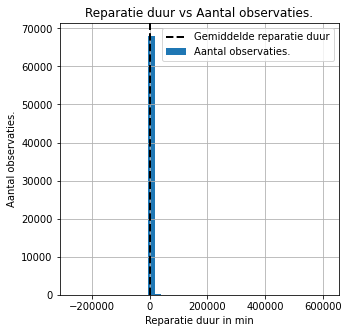

In [26]:
dataset[target].hist(figsize=(5,5), bins=40) # hist
plt.axvline(dataset[target].mean(), color='black', linestyle='dashed', linewidth=2) # add mean line
plt.legend(["Gemiddelde reparatie duur", "Aantal observaties."], loc="upper right") # legend
plt.title("Reparatie duur vs Aantal observaties."), plt.xlabel("Reparatie duur in min"), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

Zoals te zien is hierboven, is ook de histogram onleesbaar net als de eerste describe die we hebben gedaan.
Laten we daarom opnieuw een histogram plotten die alleen naar storingen kijkt van 1 minuut t/m 6 uur.

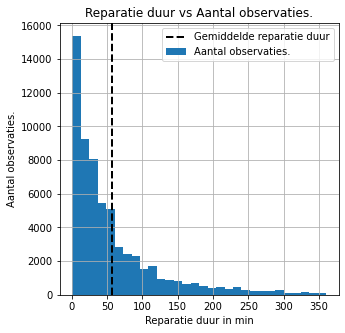

In [27]:
dataset[target][zero_360_filter].hist(figsize=(5,5), bins=30) # hist
plt.axvline(dataset[target][zero_360_filter].mean(), color='black', linestyle='dashed', linewidth=2) # add mean line
plt.legend(["Gemiddelde reparatie duur", "Aantal observaties."], loc="upper right") # legend
plt.title("Reparatie duur vs Aantal observaties."), plt.xlabel("Reparatie duur in min"), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

Reparatie duur gefilterd op groter dan 0 minuten en kleiner gelijk aan 360 minuten heeft een log-normale rechtscheve verdeling.
Er zijn veel korte reparatie-duren. De hoeveelheid storingen loopt lognormaal af per hoe lang de reparatie duur is.

##### Uitschieters

Om een visueel beeld te krijgen van de spreiding/uitschieters van de reparatie duur wordt deze getoond in een boxplot.
We kijken dit keer gelijk alleen naar reparatie-duren binnen 1 en 360 minuten.

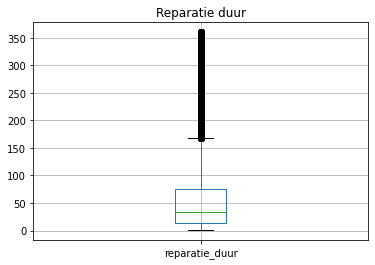

In [28]:
dataset[zero_360_filter].boxplot(target)
plt.title("Reparatie duur")
plt.show()

De grootste niet uitschieter ligt rond de 160 +-, er zitten alleen uitschieters aan de rechterkant van de getallijn.
Deze uitschieters behandelen we niet verder omdat we de data al hebben gefilterd op maximaal 360 minuten en dit dus **waarschijnlijk** nieuw geintroduceerde uitschieters zijn.

#### Data preparation
Zoals eerder beschreven tijdens de data understanding fase heeft ProRail laten weten vooral geïnteresseerd te zijn in de vertragingen waarvan de oorzakende storing maximaal één werkdag lang is.
Daarom halen we alle rijen weg die niet een functieherstel duur hebben van kleiner dan of gelijk aan 360 minuten (6 uur). Hiermee wordt gelijk een groot gedeelte van de **uitschieters** verwijderd.

Controleren hoeveel data overblijft na het filteren.

In [29]:
total = dataset[target].count()
print(f"{round(zero_360_filter.sum() / total * 100)}% van de data is over")

91% van de data is over


Ongeveer 90% van de data gaat over storingen van 1 tot 360 minuten, de rest droppen we.

In [30]:
dataset = dataset[zero_360_filter]

De target-kolom is nu klaar om gemoduleerd te worden.

### Baseline Model
Het is belangrijk om een baseline te hebben. Dit is een rudimentaire voorspelling, die we als lat leggen voor onze andere modellen. Omdat het meetniveau van de target variabele continu is wordt voor een uiteindelijk een regressie model gebruikt. Voor een baseline voor een regressie model kunnen we een centrummaat zoals het gemiddelde of de mediaan.

##### Het splitsen van de dataset
We splitsen de data op in een train- en testset.

In [31]:
X = dataset.drop(target ,axis=1)
y = dataset[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Baseline model maken en fitten
Als baseline strategie raden we steeds het gemiddelde van onze nieuwe targetkolom, reparatie_duur.

In [32]:
baseline = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

In [33]:
y_predict = baseline.predict(X_test)

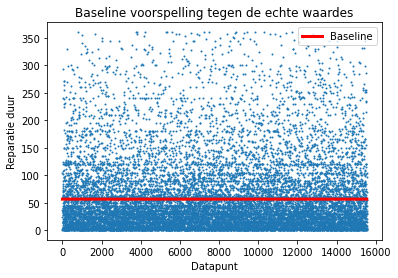

 RMSE Baseline model: 65


In [34]:
plt.plot(y_predict, c='r', linewidth=3)
plt.scatter(x=np.arange(len(X_test)), y=y_test, s=1)

plt.title("Baseline voorspelling tegen de echte waardes")
plt.xlabel("Datapunt")
plt.ylabel("Reparatie duur")
plt.legend(["Baseline"], loc="upper right")
plt.show()

baseline_rmse = round(mean_squared_error(y_test, y_predict, squared=False))
print(f" RMSE Baseline model: {baseline_rmse}")

Voor elke voorspelling die we doen, door het gemiddelde steeds te raden, zitten we er gemiddeld 65 naast. Dit is een lange tijd maar dat is ook te verwachten, zoals in de grafiek te zien. De spreiding van de punten is erg verdeeld ten opzichte van de rode lijn, onze voorspelling.

### Business Understanding model 1

In het interview met ProRail hebben we gevraagd naar de mogelijk belangrijke attributen die mee kunnen helpen bij het voorspellen van de functiehersteltijd.
Hierop kregen we de volgende paar attributen:
- Type storing.
- Tijdstip dat de aannemer ter plaatse er is.
- Prognose van de storingsduur.
- Misschien het contractgebied en aannemer.

### Data understanding model 1

Met behulp van de [data dictionary](https://canvas.hu.nl/courses/27143/pages/data?module_item_id=588747) hebben we de volgende kolommen gevonden die overeen lijken te komen met de mogelijk belangrijke attributen volgens ProRail.

Namelijk de volgende kolommen:
-tm_oorz_code, Oorzaak code
-stm_aanntpl_ddt, Aannemer ter plaatse datumtijd
-stm_progfh_in_ddt, Prognose functieherstel datumtijd

We willen a.d.h.v de volgende features testen in een model.
- Oorzaak code.
- Oorzaak groep.
- Dagdeel aannemer ter plaatse (bijv s'ochtends).
- Reparatie duur prognose.

De eerste feature die we gaan behandelen is de Reparatie prognose. Als we deze onderzocht en opgeschoond hebben kan onderzoeksvraag 2: "Hoe accuraat zijn de prognoses van de aannemers? En zijn deze optimistisch of pessimistisch?" worden beantwoord.

Eerst moet onderzocht welke prognose de gene is van de aannemer wanneer hij ter plaatse is.

In [35]:
dataset_m1 = dataset.copy()

Mogelijke kolommen die informatie geven over de prognose van de aannemer wanneer hij ter plaatse is:
-progfh_in (initiële prognose bij melding?)
-progfh_gw_lwd (laatst gewijzigde?)
-progf_gw (gewijzigde?).

In [36]:
prog_cols = ['stm_progfh_in_ddt', 'stm_progfh_in_invoer_ddt','stm_progfh_gw_lwd_ddt', 'stm_progfh_gw_ddt','stm_fh_ddt']

Mogelijke kolommen voor prognoses progfh_in (initiële prognose bij melding?), progfh_gw_lwd (laatst gewijzigde?) en progf_gw (gewijzigde?).

In [37]:
dataset_m1[prog_cols].head(10)

,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_gw_ddt,stm_fh_ddt
592816,2014-01-13 10:50:00,2014-01-13 09:50:58,NaT,NaT,2014-01-13 10:29:00
680751,2015-01-30 19:45:00,2015-01-30 19:21:50,NaT,NaT,2015-01-30 19:20:00
760628,NaT,NaT,NaT,NaT,2016-04-20 12:20:48
237571,2006-08-06 12:27:00,2006-08-06 11:29:29,NaT,NaT,2006-08-06 12:19:00
849077,2017-09-26 13:31:00,2017-09-19 13:33:37,NaT,NaT,2017-09-19 13:34:00
679491,2015-01-26 00:15:00,2015-01-26 00:18:09,NaT,NaT,2015-01-26 00:15:00
341653,2009-04-11 21:45:00,2009-04-11 21:21:59,NaT,NaT,2009-04-11 21:15:00
304567,2008-05-06 12:01:00,2008-05-06 12:02:08,NaT,NaT,2008-05-06 12:07:00
515604,2013-03-01 09:52:00,2013-03-01 10:00:01,NaT,NaT,2013-03-01 09:54:00
498789,2012-12-30 15:00:00,2012-12-30 14:57:57,NaT,NaT,2012-12-30 14:50:00


De gewijzigde en laatst gewijzigde prognoses bevatten veel foutieve waardes.
Laten we dit verder onderzoeken.

We bekijken het aantal NAN waardes per prognose kolom.

In [38]:
dataset_m1[prog_cols].isna().sum()

stm_progfh_in_ddt           10557
stm_progfh_in_invoer_ddt    17268
stm_progfh_gw_lwd_ddt       56374
stm_progfh_gw_ddt           56374
stm_fh_ddt                      0
dtype: int64

Beide gw en lwd hebben evenveel NAN waardes.

In [39]:
print(round((dataset_m1['stm_progfh_gw_ddt'].isna().sum()/dataset_m1.shape[0])*100), "% van de gw en gw lwd prognose zijn NAN waardes")

91 % van de gw en gw lwd prognose zijn NAN waardes


Laten we naar data kijken waar wel een gewijzigde prognose aanwezig is.

In [40]:
dataset_m1[['stm_sap_meld_ddt',*prog_cols, 'reparatie_duur']].dropna().head(15)

,stm_sap_meld_ddt,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_gw_ddt,stm_fh_ddt,reparatie_duur
223079,2006-03-19 11:15:15,2006-03-19 12:45:00,2006-03-19 11:58:41,2006-03-19 12:51:49,2006-03-19 12:45:00,2006-03-19 12:51:00,54
663916,2014-10-20 16:32:00,2014-10-20 19:30:00,2014-10-20 19:32:06,2014-10-21 03:50:43,2014-10-20 19:30:00,2014-10-20 19:24:00,84
224295,2006-03-31 13:33:00,2006-03-31 16:25:00,2006-03-31 15:27:34,2006-04-26 10:35:15,2006-05-17 16:00:00,2006-03-31 16:49:00,85
246192,2006-11-01 00:35:00,2006-11-01 10:10:00,2006-11-01 09:09:27,2006-11-01 11:29:00,2006-11-01 10:10:00,2006-11-01 11:26:00,138
368676,2009-12-17 15:12:00,2009-12-22 10:00:00,2009-12-22 09:43:47,2009-12-23 14:52:37,2009-12-22 10:00:00,2009-12-22 09:44:00,43
395786,2010-07-14 13:55:00,2010-07-14 16:30:00,2010-07-14 16:14:45,2010-07-15 08:27:59,2010-07-14 16:30:00,2010-07-14 16:10:00,103
579910,2013-11-21 04:40:00,2013-11-21 16:00:00,2013-11-21 09:21:56,2013-11-21 15:23:40,2013-11-21 16:01:00,2013-11-21 13:39:00,279
391185,2010-06-15 00:31:00,2010-06-15 02:15:00,2010-06-15 01:27:58,2010-06-15 12:11:08,2010-06-15 03:15:00,2010-06-15 02:45:00,92
481876,2012-07-26 09:36:00,2012-07-26 10:51:00,2012-07-26 11:40:07,2012-07-27 15:50:37,2012-07-26 10:51:00,2012-07-26 10:44:00,3
300824,2008-03-30 18:25:00,2008-03-30 20:15:00,2008-03-30 19:17:25,2008-03-31 01:13:29,2008-03-31 00:01:00,2008-03-30 19:16:00,1


Opvallend is dat de 'gw prognose' in de meeste gevallen gelijk is aan de 'in prognose' of een minder accurate prognose is.
'gw lwd prognose' is in veel gevallen onzinnig in vergelijking met de 'in prognose'.
We gingen er van uit dat de gewijzigde prognoses door de aannemers gemaakt zijn. En de initiële prognose automatisch bij de melding door TIS (Trein Incident Scenario).
Maar het lijkt er op dat de 'in prognose' accurater is dan de gw (lwd) prognoses. En de 'in prognoses' te accuraat zijn om vanaf het begin van de melding te zijn gemaakt.

Er is ook een kolom over de invoer van de 'in prognose', laten we vergelijken hoeveel van deze invoeren waren nadat de aannemer ter plaatse kwam.

In [41]:
print(round(((dataset_m1['stm_progfh_in_invoer_ddt'] >= dataset_m1['stm_aanntpl_ddt']).sum()/dataset_m1['stm_aanntpl_ddt'].count()) * 100), '% van de invoer is later dan aannemer ter plaatse')

70 % van de invoer is later dan aannemer ter plaatse


Het overgrote deel van de 'invoer in prognose' is nadat de aannemer ter plaatse was.

In [42]:
print(round(((dataset_m1['stm_progfh_in_invoer_ddt'] >= dataset_m1['stm_fh_ddt']).sum()/dataset_m1['stm_aanntpl_ddt'].count()) * 100), '% van de invoer is later dan functieherstel')

47 % van de invoer is later dan functieherstel


Maar ook is ongeveer 50% van de 'invoer in prognose' na de daadwerkelijke functieherstel tijd.
Hierdoor gaan we er vanuit dat de invoer-datum iets is wat achteraf wordt ingevuld en niet het moment is dat de prognose door de aannemer wordt gemaakt.
Met dit in gedachte en de eerder twijfelbare betrouwbaarheid/overlap van de 'gw (lwd) prognoses' in verhouding tot de 'in prognose' gaan we er van uit dat de 'in prognose' de prognose is die de aannemer ter plaatse doet. En dat er in de data dus **geen** prognose aanwezig is die niet door de aannemer ter plaatse is gedaan.

#### Data preparation model 1

De kolommen nodig om de reparatie duur prognose te berekenen zijn:
-stm_progfh_in_ddt
-stm_aanntpl_ddt

De kolom stm_aanntpl_ddt is al schoongemaakt om de target-variabele te construeren, daarom maken we alleen nog de kolom stm_progfh_in_ddt schoon.

Aantal NAN waardes controleren.

In [43]:
dataset_m1['stm_progfh_in_ddt'].isna().sum()

10557

Aantal rijen waar het tijdstip van de prognose 00:00:00 was, dit duid op foutieve invoer zoals eerder besproken.

In [44]:
(dataset_m1['stm_progfh_in_tijd'] == "00:00:00").sum()

10591

Zo goed als alle NAN waardes in de ddt kolom komen overeen met een 00:00:00 tijdstip in de tijd kolomm. Hierdoor gaan we ervan uit dat zo goed als alle deze NAN waardes in ddt foutieve invoer waardes zijn en droppen we deze.

In [45]:
dataset_m1.dropna(subset=['stm_progfh_in_ddt'], inplace=True)

Kolom reparatie duur prognose kan nu aangemaakt worden.

In [46]:
dataset_m1['reparatie_duur_prog'] = ((dataset_m1['stm_progfh_in_ddt'] - dataset_m1['stm_aanntpl_ddt']).dt.total_seconds()/60).astype('int')

Ook kijken we alleen naar prognoses waarvan de prognose op een later tijdstip is dan wanneer de aannemer ter plaatse kwam.
Dit doen we door alle nul en negatieve prognoses eruit te halen.

In [47]:
dataset_m1 = dataset_m1[dataset_m1['reparatie_duur_prog'] > 0]

Omdat we naar reparatie-duren t/m 6 uur kijken.
Kijken we ook alleen naar prognoses t/m 6 uur. Om zo te vermijden dat er extreem pessimistiche prognoses ontstaan als we naar hogere prognoses kijken dan daadwerkelijke reparatie-duren.

In [48]:
dataset_m1 = dataset_m1[dataset_m1['reparatie_duur_prog'] <= 360]

De prognose is nu aangemaakt en schoon om terug te gaan naar data understanding.

In [49]:
feature = 'reparatie_duur_prog'

##### meetniveau

Reparatie duur prognose is net zoals de reparatie duur, in minuten en is dus van een continu meetniveau.

In [50]:
pd.DataFrame({'Kolom': [target, feature], 'Meetniveau': ['Continu', 'Continu']})

,Kolom,Meetniveau
0,reparatie_duur,Continu
1,reparatie_duur_prog,Continu


##### Centrum en spreidingsmaten

In [51]:
dataset_m1[[feature,target]].describe().round()

,reparatie_duur_prog,reparatie_duur
count,48041.0,48041.0
mean,73.0,57.0
std,69.0,63.0
min,1.0,1.0
25%,25.0,15.0
50%,57.0,36.0
75%,93.0,75.0
max,360.0,360.0


Gemiddelde reparatie duur van rond de 70 minuten met een standaard-deviatie van 70 minuten.
50% van de prognoses valt binnen 25 en 90 minuten, terwijl dit voor de daadwerkelijke reparatie duur binnen de 15 en 75 minuten is.
Aan alle maten is te zien dat de prognose hoger worden ingeschat dan de reparatie duur zelf.

##### Correlatie

Er wordt een lineair verband verwacht tussen de prognose en de daadwerkelijke reparatie tijd.
Om dit te valideren controleren we de Pearsons product-momentcorrelatiecoëfficiënt die een lineair verbandt aanduidt met een sterkte tussen de -1 en 1.

In [52]:
dataset_m1[[target, feature]].corr()

,reparatie_duur,reparatie_duur_prog
reparatie_duur,1.000000,0.778211
reparatie_duur_prog,0.778211,1.000000


De twee variabelen hebben een correlatie van 0.78 dit is een sterke positieve correlatie.
Om een visueel beeld van de correlatie te krijgen plotten we een scatterplot.

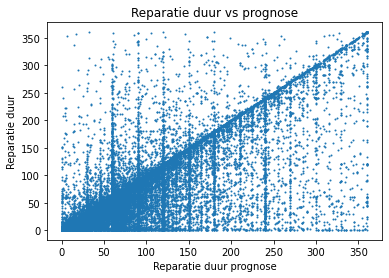

In [53]:
dataset_m1.plot.scatter(x=feature, y=target, s=1)
plt.xlabel("Reparatie duur prognose")
plt.ylabel("Reparatie duur")
plt.title("Reparatie duur vs prognose")
plt.show()

We zien dat bij relatief lage reparatie-duren vaak bizar hoge prognoses worden opgegeven zoals 6 uur wanneer de daadwerkelijke hersteltijd 1 tot enkele minuten duurt.
Hiermee zijn we naar onze product owner gestapt, want het lijkt er op alsof er veel foutieve/onrealistiche prognoses zijn ingevuld. De productowner liet weten een afwijking van 2 uur teveel te vinden voor daadwerkelijke hersteltijden van 1 minuut en voor een afwijking van 24 uur teveel voor een hersteltijd van 6 uur. We zijn hierdoor tot de afspraak gekomen om een interpolatie op de data te doen om zo alles onder een lineaire lijn als onzin prognose te beschouwen.

In [54]:
interpolater = interp1d([1, 360], [120, 1440]) # maak lineaire interpolatie functie.

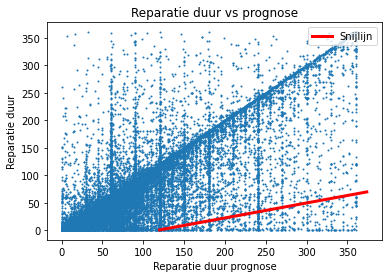

In [55]:
dataset_m1[dataset_m1[feature]<1440].plot.scatter(x=feature, y=target,s=1)
plt.plot(interpolater([1,70]), [1, 70], c='red', linewidth=3)

plt.xlabel("Reparatie duur prognose")
plt.ylabel("Reparatie duur")
plt.title("Reparatie duur vs prognose")

plt.legend(['Snijlijn'],loc="upper right")
plt.show()

Alles onder de rode snijlijn wordt als foutieve prognose beschouwd.

#### Data preparation model 1

Volgens de beschreven snijlijn verwijderen we *onzinnige* prognoses.

In [56]:
dataset_m1 = dataset_m1[(dataset_m1[feature]) < (interpolater(dataset_m1[target]))]

#### Data understanding model 1

Nu de foutieve prognoses verwijderd zijn kunnen we verder met data-understanding over de reparatie duur prognose.

##### Centrum en spreidingsmaten

Omdat we een deel van de prognoses als foutief hebben beschouwd en hebben verwijderd kijken we opnieuw naar de centrum en spreidingsmaten.

In [57]:
dataset_m1[[feature,target]].describe().round()

,reparatie_duur_prog,reparatie_duur
count,47423.0,47423.0
mean,71.0,58.0
std,66.0,63.0
min,1.0,1.0
25%,25.0,15.0
50%,55.0,36.0
75%,90.0,75.0
max,360.0,360.0


De spreiding van de prognose is na het verwijderen van de "foutieve" prognoses ongeveer hetzelfde gebleven.
Nogsteeds is er hetzelfde verschil te zien tussen de daadwerkelijke duur en de prognose.
De prognoses zijn gebasseerd op de centrum en spreidingsmaten pessimistisch.

Visueel beeld van de verdeling krijgen met behulp van een histogram die beide de prognose en reparatie duur toont.

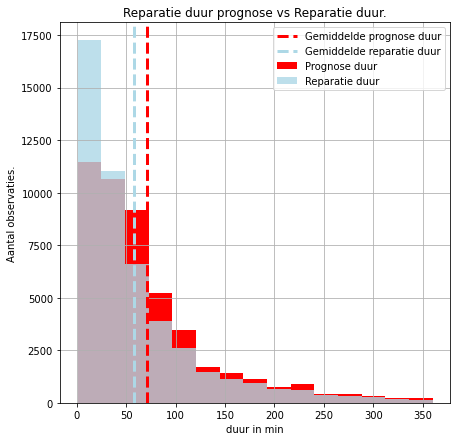

In [58]:
dataset_m1[feature].hist(figsize=(7,7), bins=15, alpha=1, color='red') # hist
dataset_m1[target].hist(bins=15, alpha=.8, color='lightblue') # hist

plt.axvline(dataset_m1[feature].mean(), color='red', linestyle='dashed', linewidth=3) # add mean line
plt.axvline(dataset_m1[target].mean(), color='lightblue', linestyle='dashed', linewidth=3) # add mean line

plt.legend(['Gemiddelde prognose duur', 'Gemiddelde reparatie duur', 'Prognose duur','Reparatie duur'], loc="upper right") # legend
plt.title("Reparatie duur prognose vs Reparatie duur."), plt.xlabel("duur in min"), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

De reparatie duur prognose lijkt een rechts-scheve lognormale verdeling te hebben, net als de reparatie duur.
Er is te zien dat er meer korte reparatie duren zijn ten opzichte van de prognoses. En er meer lange prognoses zijn ten opzichte van de reparatie-duren.

#### Uitschieters

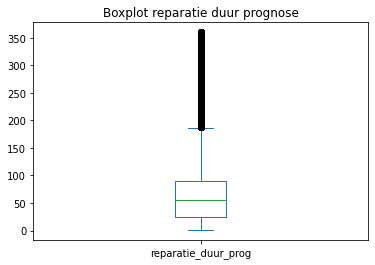

In [59]:
dataset_m1[feature].plot.box()
plt.title('Boxplot reparatie duur prognose')
plt.show()

De reparatie duur prognose heeft veel mild en extreme uitschieters aan de rechter kant van de getallijn.
Echter hebben we al een hoop van de uitschieters verwijderd met behulp van de besproken snijlijn en alleen naar prognoses onder de 6 uur te kijken, daarom beschouwen we deze uitschieters als valide data punten.

#### Correlatie
Eerst was de correlatie coëfficient 0.78, laten we deze opnieuw berekenen na het opschonen van de prognoses.

In [60]:
dataset_m1[[target, feature]].corr()

,reparatie_duur,reparatie_duur_prog
reparatie_duur,1.000000,0.836026
reparatie_duur_prog,0.836026,1.000000


De prognose en de daadwerkelijke reparatie duur hebben een lineaire correlatie van .83, de correlatie is nog sterker geworden.
Een lineair regressie model is hierdoor interresant.

We maken een scatterplot aan om de lineaire correlatie te visualiseren.

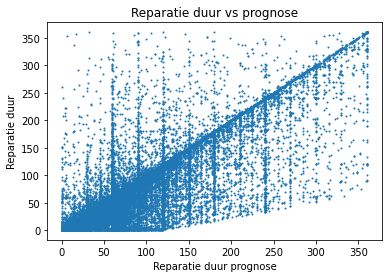

In [61]:
dataset_m1.plot.scatter(x=feature, y=target, s=1)
plt.xlabel("Reparatie duur prognose")
plt.ylabel("Reparatie duur")
plt.title("Reparatie duur vs prognose")
plt.show()

#### Kwaliteit prognose
Eerder hebben we al aangetoond dat de prognoses van de aannemer pessimistisch zijn, zoals ook verteld is door de product-owner.
Nu de prognose opgeschoond en geanalyseerd zijn, kunnen we testen hoeveel de prognose gemiddeld afwijkt door de RMSE te berekenen.

In [62]:
rmse_prognose = round(mean_squared_error(dataset_m1[target], dataset_m1[feature], squared=False),2)
print(f"Prognose van de aannemer heeft een RMSE van: {rmse_prognose}")

Prognose van de aannemer heeft een RMSE van: 39.44


De RMSE van de prognose is 39.44. De RMSE van de baseline is 65, zoals verwacht voorspelt de aannemer aanzienlijk beter dan de baseline.
Het doel van onze modellen is dan ook niet meer beter scoren dan de baseline, maar ook beter dan de prognoses van de aannemer.

#### Modeling model 1

Vanwege het vinden van een sterke lineaire correlatie van 0.80 +.
Gaan we eerst een polynoom model maken, hiermee testen we gelijk lineaire regressie (polynome regressie met 1 polynoom).
Hierbij gebruiken we enkel de prognose als feature om de target, de reparatie duur te voorspellen.

De eerste stap is het splitten van de data in een train en test set.

In [63]:
X = dataset_m1[feature].values.reshape(-1,1) # reshape, nodig omdat de feature 1 dimensie heeft.
y = dataset_m1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Polynoom regressie model maken, trainen en hyper-parameter tuning

We maken 10 verschillende polynome regressie modellen en trainen deze op de train set.
Om zo te testen welke hyperparameter-setting (het aantal polynomen) het beste scoort qua RMSE op de test set.
Het aantal polynomen wat getest wordt is 1 t/m 10.

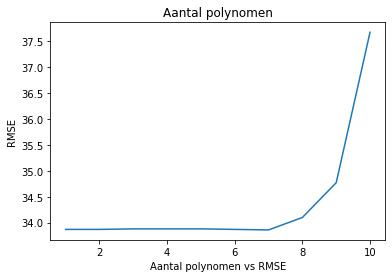

{'Aantal polynomen: 1': 33.87,
 'Aantal polynomen: 2': 33.87,
 'Aantal polynomen: 3': 33.88,
 'Aantal polynomen: 4': 33.88,
 'Aantal polynomen: 5': 33.88,
 'Aantal polynomen: 6': 33.87,
 'Aantal polynomen: 7': 33.86,
 'Aantal polynomen: 8': 34.1,
 'Aantal polynomen: 9': 34.77,
 'Aantal polynomen: 10': 37.67}

In [64]:
polynomials = np.arange(1, 11) # range of polynomials to test
scores =  [round(mean_squared_error(y_test,make_pipeline(PolynomialFeatures(p),LinearRegression()).fit(X_train,y_train).predict(X_test), squared=False),2) for p in polynomials] # make, train and list the score of each model
rmse_poly = min(scores) # RMSE is minimale RMSE van alle geteste modellen.
# plot grafiek aantal polynomen vs RMSE score.
plt.plot(polynomials, scores)
plt.xlabel("Aantal polynomen vs RMSE")
plt.ylabel("RMSE")
plt.title("Aantal polynomen")
plt.show()

dict(list(zip(map(lambda x: f"Aantal polynomen: {x}", polynomials), scores))) # print aantal polynomen + gescoorde RMSE

Een polynoom regressie model met 1 t/m 7 polynomen scoren ongeveer dezelfde RMSE, namelijk: 33.9.
We besluiten om het model met 1 polynoom te gebruiken, oftwel een lineair regressie model.
Dit is het meest eenvoudige polynome regressie model die ook het beste scoort.

#### Model 1 lineaire regressie visualiseren.

Lineaire regressie model visualiseren om een idee te krijgen hoe ons model voorspelt ten opzichte van de gebruikte data.
De lineaire regressie kan in 2d worden geplot omdat er maar een enkele feature wordt gebruikt.

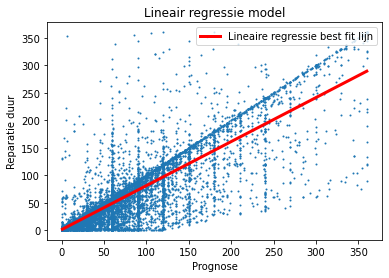

In [65]:
lin_regr = LinearRegression().fit(X_train,y_train)
line = np.linspace([1], 360, 1000)
plt.plot(line, lin_regr.predict(line),'-r',linewidth=3)
plt.scatter(X_test, y_test,s=1)

plt.xlabel("Prognose")
plt.ylabel("Reparatie duur")
plt.title("Lineair regressie model")
plt.legend(['Lineaire regressie best fit lijn'], loc='upper right')
plt.show()

In [66]:
print(f"RMSE: {rmse_poly}, RMSE is {100-round(rmse_poly/rmse_prognose*100)}% lager ten opzichte van de prognose en {100-round(rmse_poly/baseline_rmse*100)}% lager ten opzichte van de baseline.")

RMSE: 33.86, RMSE is 14% lager ten opzichte van de prognose en 48% lager ten opzichte van de baseline.


Met een eenvoudige lineaire transformatie over de reparatie duur prognose van de aannemer kan er een accuratere voorspelling worden gedaan dan die van de aannemer zelf.
We scoren hiermee een RMSE van 34, dit is 14% lager dan de RMSE van de prognose gemaakt door de aannemer.
Daarom adviseren wij dit model als verbetering op de prognose van de aannemer.

##### Model 2 Decision tree regressor

Een ander regressie algoritme is een regressie beslis boom. Een beslis boom kan naast lineaire verbanden ook gebruik maken van complexere relaties tussen de features en target variabelen.
Deze testen we ook met enkel de prognose als feature om te testen welk model het best werkt met enkel de prognose als input.

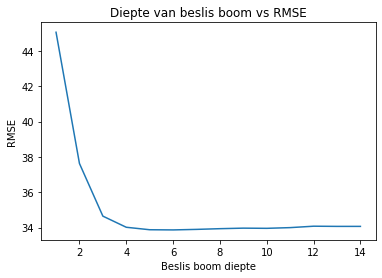

{'diepte 1': 45.06,
 'diepte 2': 37.63,
 'diepte 3': 34.65,
 'diepte 4': 34.02,
 'diepte 5': 33.88,
 'diepte 6': 33.87,
 'diepte 7': 33.9,
 'diepte 8': 33.94,
 'diepte 9': 33.97,
 'diepte 10': 33.96,
 'diepte 11': 34.0,
 'diepte 12': 34.08,
 'diepte 13': 34.07,
 'diepte 14': 34.07}

In [67]:
depths = np.arange(1, 15)
scores =  [round(mean_squared_error(y_test,DecisionTreeRegressor(max_depth=d).fit(X_train,y_train).predict(X_test), squared=False),2) for d in depths]
rmse_regr_tree = min(scores)
plt.plot(depths, scores)
plt.xlabel("Beslis boom diepte")
plt.ylabel("RMSE")
plt.title("Diepte van beslis boom vs RMSE")
plt.show()
dict((zip(map(lambda x: f"diepte {x}", depths), scores)))

In [68]:
print(f"RMSE: {rmse_regr_tree}, RMSE is {100-round(rmse_regr_tree/rmse_prognose*100)}% lager ten opzichte van de prognose en {100-round(rmse_regr_tree/baseline_rmse*100)}% lager ten opzichte van de baseline.")

RMSE: 33.87, RMSE is 14% lager ten opzichte van de prognose en 48% lager ten opzichte van de baseline.


##### Conclusie

De regressie boom scoort vanaf diepte 5 een vergelijkbare RMSE als de polynome/lineaire regressie.
We besluiten tussen deze twee modellen nogsteeds voor de lineaire regressie te kiezen. Omdat lineaire regressie een eenvoudiger uit te leggen model is en ook een continue voorspelling doet. Daarentegen is het aantal voorspellingen wat een beslisboom kan doen gelinkt aan zijn diepte.

Model 1 exporteren, zodat het model in praktijk kan worden gebracht via een gebruikersapplicatie.

In [69]:
pickle.dump(lin_regr, open('model_1.pkl', 'wb'))

#### Data-understanding Model 3

Voor model 3 willen de eerder besproken features, aanbevolen door de product-owner, gaan onderzoeken.
- Type storing.
- Tijdstip dat de aannemer ter plaatse er is.
- Prognose van de storingsduur (al geanalyseerd en schoongemaakt).
- Misschien het contractgebied en aannemer.

In [70]:
dataset_m3 = dataset_m1.copy()

#### Meetniveaus

In [71]:
pd.DataFrame({'Kolom': ["stm_oorz_groep", "stm_oorz_code", "aanntpl_dagdeel", feature], 'Meetniveau': ['Nominaal','Nominaal','Ordinaal','Continu']})

,Kolom,Meetniveau
0,stm_oorz_groep,Nominaal
1,stm_oorz_code,Nominaal
2,aanntpl_dagdeel,Ordinaal
3,reparatie_duur_prog,Continu


De features oorzaak groep en oorzaak code zijn van nominaal meetniveau, ze zijn beide een categorie zonder volgordelijkheid.
Een dagdeel is van ordinaal meetniveau, het is categoriaal maar er zit wel volgordelijkheid in.

De prognose is al onderzocht tijdens datapreparation voor model 1 en de kolom aanntpl_dagdeel moet nog gemaakt worden.
Daarom analyseren we eerst kolommen oorzaakgroep en oorzaakcode.

Eerst kijken we naar de verschillende oorzaakgroepen en hoe vaak ze voorkomen.

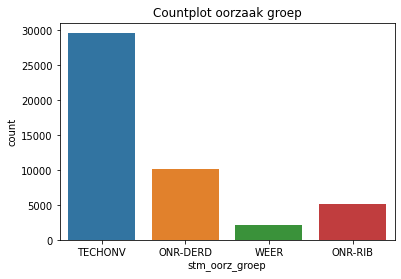

In [72]:
sns.countplot(x='stm_oorz_groep',data=dataset_m3)
plt.title('Countplot oorzaak groep')
plt.show()

Er zijn 4 verschillende waardes in de kolom oorzaak groep van meest voorkomend naar minst voorkomend:
-TECHONV
-ONR-DERD
-ONR-RIB
-WEER

Omdat er teveel permutaties zijn van de oorzaaks code kunnen we hier geen leesbare countplot van maken.
Daarom laten een tabel zien van de oorzaakcodes en de frequentie dat ze voorkomen.

In [73]:
dataset_m3['stm_oorz_code'].value_counts()

221.0    6393
218.0    5918
215.0    5583
135.0    2535
145.0    2442
133.0    2414
151.0    2175
298.0    2025
143.0    1632
213.0    1339
225.0    1151
140.0    1008
147.0     958
203.0     752
212.0     738
146.0     540
219.0     511
207.0     508
183.0     463
241.0     454
230.0     452
226.0     426
150.0     414
184.0     412
181.0     400
182.0     369
227.0     368
149.0     338
186.0     321
209.0     283
214.0     268
228.0     267
299.0     262
154.0     248
223.0     222
210.0     213
220.0     211
148.0     183
187.0     180
294.0     176
222.0     173
132.0     159
211.0     142
144.0     134
229.0     131
201.0     110
240.0     106
242.0      70
204.0      67
188.0      60
250.0      57
208.0      55
141.0      48
185.0      44
224.0      43
234.0      37
142.0      29
235.0      24
231.0      22
189.0      13
134.0      10
206.0      10
239.0       8
130.0       8
131.0       7
999.0       4
202.0       3
136.0       3
233.0       2
205.0       1
Name: stm_oorz_code,

De top 6 voorkomende oorzaak codes zijn:
- 221;Overigtechnisch
- 218;Bijonderzoekinorde/geenoorzaakgevonden
- 215;Onderdeeldefectdooronbekendeoorzaak
- 135;Overigprocessen
- 145;Vandalisme
- 133;Werkzaamheden

Ook valt op dat er een oorzaaks code 999 enkele keren voorkomt in de data, deze oorzaaks code staat niet beschreven in de data-dictionary en zetten we later om naar oorzaaks code 299 (niet gemeld).

#### Uitschieters
Er zijn teveel permutaties van de oorzaaks code om hiervan een boxplot te maken tegenover de target variabele.
De kolom oorzaak groep heeft maar 4 permutaties en kan daardoor wel geanalyseerd worden met een boxplot.

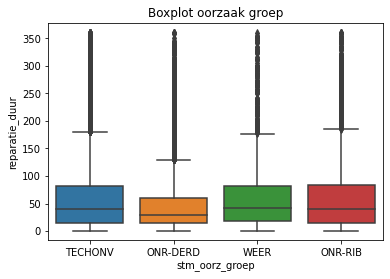

In [74]:
sns.boxplot(x='stm_oorz_groep', y=target, data=dataset_m3)
plt.title('Boxplot oorzaak groep')
plt.show()

Alle 4 de oorzaak groepen hebben veel uitschieters aan de rechterkant van de getallijn.
De oorzaak groep ONR-DERD is de enige oorzaak groep die merkwaardig lijkt af te wijken ten opzichte van de rest van de oorzaak groepen.
Storingen met deze oorzaak groep zijn iets lager verdeeld qua kwartielen dan de rest.

Om data-understanding voort te zetten moet eesrt de kolom dagdeel aanntpl worden aangemaakt en schonen we ook de al geanalyseerde feature kolommen op.

#### Data-preparation Model 3

Kolom voor kolom schoonmaken beginnend met oorzaak code.

Tijdens de data-preparation fase viel op dat er een rijen waren met de oorzaaks code 999.
Deze staan niet in de datadictionary, deze zetten we om naar de oorzaakscode 299.
Betekenis oorzaakcode 299: Niet gemeld

In [75]:
print((dataset_m3['stm_oorz_code'] == 999).sum(), 'rijen met oorzaak code 999')

4 rijen met oorzaak code 999


In [76]:
dataset_m3['stm_oorz_code'] = dataset_m3['stm_oorz_code'].replace([999],299.0)

##### NAN waardes

In [77]:
print(f"{round((dataset_m3['stm_oorz_code'].isna().sum()/dataset_m3['stm_oorz_code'].count())*100, 1)}% van de oorzaak codes is een NAN")

0.6% van de oorzaak codes is een NAN


Er zijn een aantal NAN waardes in de kolom oorzaak code. Uit de data dictionary blijken er geen andere kolommen te zijn waar we de oorzaak code staat vermeld. We gaan er vanuit dat in deze gevallen er geen oorzaak code is gemeld. Daarom vervangen we ook de NAN waardes met de oorzaak code 299.

In [78]:
dataset_m3['stm_oorz_code'] = dataset_m3['stm_oorz_code'].fillna(299.0)

De kolom oorzaak code is nu schoon.

Als volgende stap kan de nieuwe feature aanntpl_dagdeel gemaakt worden. Hiermee willen we onderzoeken of het tijdstip dat de aannemer ter plaatse was invloed heeft op de betrouwbaarheid van hun prognose.
Hiervoor verdelen we tijdstippen onder in dagdelen:
  00:00 tot 06:00: nacht
  06:00 tot 12:00: ochtend
  12:00 tot 18:00: middag
  18:00 tot 00:00: avond.

In [79]:
dataset_m3['aanntpl_dagdeel'] = pd.cut(dataset_m3['stm_aanntpl_ddt'].dt.hour,bins=[0,5,11,17,23],include_lowest=True,labels=['nacht', 'ochtend', 'middag', 'avond'])

In [80]:
dataset_m3[['stm_aanntpl_ddt', 'aanntpl_dagdeel']].sample(5, random_state=6)

,stm_aanntpl_ddt,aanntpl_dagdeel
382669,2010-03-31 16:33:00,middag
383672,2010-04-09 14:53:00,middag
824914,2017-01-24 18:55:24,avond
510549,2013-02-08 01:05:00,nacht
516892,2013-03-11 09:15:00,ochtend


De nieuwe kolom aanntpl_dagdeel is aangemaakt en de dagdelen komen overeen met het tijdstip.
De laatste kolom, oorzaak groep kan nu worden schoongemaakt.

In [81]:
print(f"{round((dataset_m3['stm_oorz_groep'].isna().sum()/dataset_m3['stm_oorz_groep'].count())*100, 1)}% van de oorzaak groepen is NAN")

0.6% van de oorzaak groepen is NAN


Klein genoeg deel van de data om te droppen.

In [82]:
dataset_m3.dropna(subset=['stm_oorz_groep'], inplace=True)

##### Dtypes

Dtypes van de kolommen controleren waarvan de dtypes nog niet eerder zijn behandeld.

In [83]:
dataset_m3[['stm_oorz_groep', 'aanntpl_dagdeel', 'stm_oorz_code']].dtypes

stm_oorz_groep       object
aanntpl_dagdeel    category
stm_oorz_code       float64
dtype: object

De drie kolommen horen categoriaal te zijn en worden daarom omgezet tot juiste type 'category' indien nodig.

In [84]:
dataset_m3[['stm_oorz_groep', 'stm_oorz_code']] = dataset_m3[['stm_oorz_groep', 'stm_oorz_code']].astype('category')

#### Data-preparation model 3
#### Uitschieters
Nu kan er ook van de kolom aanntpl_dagdeel een boxplot gemaakt worden om een idee te krijgen van de verdeling van de reparatie duur per dagdeel.

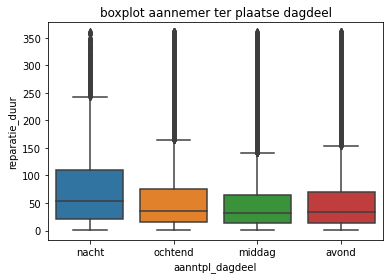

In [85]:
sns.boxplot(x='aanntpl_dagdeel', y=target, data=dataset_m3)
plt.title('boxplot aannemer ter plaatse dagdeel')
plt.show()

Er valt een verschil te zien tussen de reparatieduren bij de verschillende dagdelen.
In de nacht ligt 50% van de reparatie duren ongeveer tussen de 30 en 110, in de ochtend, middag en avond tussen de 25 en 60 +-.
Ook ligt de kleinste niet uitschieter in de nacht aanzienlijk hoger (250 min) dan bij de rest van de dagdelen (150 +- min).

### Modeling model 3

Voor het derde model gebruiken we de volgende variabelen:
- Reparatie duur prognose van de aannemer.
- Oorzaaks code van de storing.
- Oorzaaks groep van de storing.
- Dagdeel aannemer ter plaatse.

Omdat de prognose een sterk lineair verband heeft met de target willen we nogsteeds een regressie algoritme gebruiken die gebruik kan maken van deze lineaire relatie.
We hebben opnieuw voor een beslisboom regressie gekozen. Dit algoritme werkt beter ten opzichte van polynome regressie wanneer der complexe relaties zijn tussen de features en target variabele en ook wanneer er met een mix van numerieke en categoriale data wordt gewerkt zoals onze features.

Voor de beslisboom is ook geen extra feature selection nodig. De boom ontdekt zelf de meest invloedrijke variabelen.

In [86]:
features = ['stm_oorz_groep', 'aanntpl_dagdeel', 'stm_oorz_code', 'reparatie_duur_prog']
target = 'reparatie_duur'

Train en test data aanmaken.
De features encoded met get_dummies, deze encode automatisch alleen variabelen van het type category.

In [87]:
X = pd.get_dummies(dataset_m3[features], drop_first=True)
y = dataset_m3['reparatie_duur']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Model maken en Hyper-parameter tuning

Om de optimale beslis boom te vinden, testen we de RMSE score van een beslis boom met dieptes 1 t/m 14.

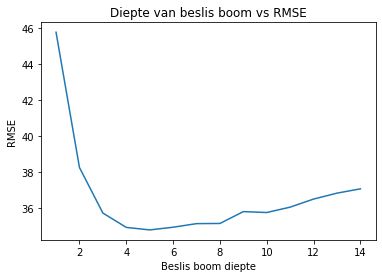

{'diepte 1': 45.79,
 'diepte 2': 38.25,
 'diepte 3': 35.71,
 'diepte 4': 34.91,
 'diepte 5': 34.77,
 'diepte 6': 34.92,
 'diepte 7': 35.12,
 'diepte 8': 35.13,
 'diepte 9': 35.79,
 'diepte 10': 35.74,
 'diepte 11': 36.04,
 'diepte 12': 36.49,
 'diepte 13': 36.82,
 'diepte 14': 37.06}

In [88]:
depths = np.arange(1, 15)
scores =  [round(mean_squared_error(y_test,DecisionTreeRegressor(max_depth=d).fit(X_train,y_train).predict(X_test), squared=False),2) for d in depths]
rmse_regr_tree_2 = min(scores)
plt.plot(depths, scores)
plt.xlabel("Beslis boom diepte")
plt.ylabel("RMSE")
plt.title("Diepte van beslis boom vs RMSE")
plt.show()
dict((zip(map(lambda x: f"diepte {x}", depths), scores)))

In [89]:
print(f"RMSE: {rmse_regr_tree_2}, RMSE is {100-round(rmse_regr_tree_2/rmse_prognose*100)}% lager ten opzichte van de prognose en {100-round(rmse_regr_tree_2/baseline_rmse*100)}% lager ten opzichte van de baseline.")

RMSE: 34.77, RMSE is 12% lager ten opzichte van de prognose en 47% lager ten opzichte van de baseline.


De beste RMSE van een beslisboom met 4 feature variabelen (waaronder de reparatie duur prognose)  is lager dan de RMSE van de beste beslisboom met die enkel de reparatie duur prognose gebruikt als feature.
Dit komt **waarschijnlijk** omdat er een aantal data punten van de prognose zijn verwijderd tijdens het behandelen van de NAN waardes van de nieuwe features.

Laten we dit testen door op dezelfde dataset een beslisboom te gebruiken die enkel de reparatie duur prognose gebruikt als feature.

In [90]:
X = dataset_m3["reparatie_duur_prog"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
depths = np.arange(1, 15)
scores =  [round(mean_squared_error(y_test,DecisionTreeRegressor(max_depth=d).fit(X_train,y_train).predict(X_test), squared=False),2) for d in depths]
print("RMSE beslisboom 1 feature beste RMSE: ", min(scores))

RMSE beslisboom 1 feature beste RMSE:  34.84


De RMSE van de beslisboom met enkel de prognose als feature scoort de exact zelfde RMSE als de beslis boom die ook de: oorzaaks code, oorzaaks groep en dagdeel aannemer ter plaatse als feature meeneemt.

#### Conclusie
Een beslisboom met de volgende feature variabelen:
- Oorzaaks code van de storing.
- Oorzaaks groep van de storing.
- Dagdeel aannemer ter plaatse.
- Prognose reparatie duur aannemer.

Heeft geen betere voorspellingskracht dan een beslisboom/lineair regressie model die enkel de prognose als feature gebruikt.
Daarom overwegen we het gebruik van dit model **niet**. Het beste en eenvoudigste model blijft de lineaire regressie om de reparatie duur te voorspellen.


#### Business-understanding 4

Onze productowner liet weten ook graag een voorspelling te kunnen doen voordat er een prognose is gemaakt door de aannnemer.
Hierop hebben wij o.a doorgevraagd welke variabelen precies al bekend zijn voor dat de aannemer de oorzaak heeft gevonden en een prognose heeft gedaan.
Dit o.a de volgende variabelen:
- Prioriteit indicatie
- Aannemer ter plaatse tijd (is bekend voor de prognose)
- Techniekveld
- Contractgebied aannemer
- Functieherstel status

Aan de hand van deze variabelen willen onderzoeken hoe accuraat we kunnen classificeren of een reparatie duur lager of hoger is dan 15min zodat de planners van de NS *voor* de prognose van de aannemer al het treinverkeer kunnen gaan hervatten, indien de storing erg kort is.


#### Data-preparation 4

Hiervoor moeten we eerst een nieuwe target variabele maken, namelijk een label met als waarde of de reparatie duur lager gelijk is dan 15 minuten.

In [91]:
dataset_m4 = dataset_m3.copy()

In [92]:
dataset_m4['reparatie_duur_<=15'] = (dataset_m4['reparatie_duur'] <= 15).astype('int').copy() # boolean to int

In [93]:
dataset_m4['reparatie_duur_<=15'].head(10)

592816    0
680751    0
237571    0
679491    0
341653    1
515604    1
498789    0
345916    0
809023    0
646478    1
Name: reparatie_duur_<=15, dtype: int32

#### Baseline classificatie

Omdat we nu een andere target proberen te voorspellen moeten we hier ook een nieuwe baseline voor maken.
Hiervoor gebruiken we een DummyClassifier omdat we met een classificatie probleem werken.

In [94]:
X = dataset_m4.drop(target ,axis=1)
y = dataset_m4['reparatie_duur_<=15']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [95]:
baseline = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
y_predict = baseline.predict(X_test)

baseline_acc = round(accuracy_score(y_test, y_predict),6)
print(f"Accuracy Baseline model: {round(baseline_acc*100)}% door altijd te voorspellen dat een reparatie duur niet korter gelijk aan 15 minuten is.")

Accuracy Baseline model: 74% door altijd te voorspellen dat een reparatie duur niet korter gelijk aan 15 minuten is.


Een accuracy score van 74% proberen wij te verbeteren met een machine learning model.

#### Data understanding
We analyseren de volgende features die bekend zijn **voor** dat de aannemer een prognose heeft gedaan:
- Prioriteit indicatie
- Aannemer ter plaatse dagdeel
- Techniekveld
- Contractgebied aannemer
- Functieherstel status

In [96]:
features = ['stm_prioriteit', 'aanntpl_dagdeel', 'stm_techn_gst', 'stm_contractgeb_mld', 'stm_fh_status']

Eerste paar rijen van de features voor model 4 bekijken.

In [97]:
dataset_m4[features].head(10)

,stm_prioriteit,aanntpl_dagdeel,stm_techn_gst,stm_contractgeb_mld,stm_fh_status
592816,5.0,ochtend,T,3.0,4.0
680751,2.0,avond,E,11.0,4.0
237571,5.0,ochtend,S,4.0,1.0
679491,4.0,avond,S,81.0,1.0
341653,4.0,avond,S,6.0,4.0
515604,4.0,ochtend,S,NaN,4.0
498789,2.0,ochtend,B,NaN,1.0
345916,2.0,ochtend,G,12.0,2.0
809023,2.0,nacht,B,27.0,1.0
646478,4.0,middag,K,71.0,1.0


##### Meetniveaus

In [98]:
pd.DataFrame({'Kolom': features, 'Meetniveau': ['Ordinaal','Ordinaal','Nominaal','Nominaal', 'Ordinaal']})

,Kolom,Meetniveau
0,stm_prioriteit,Ordinaal
1,aanntpl_dagdeel,Ordinaal
2,stm_techn_gst,Nominaal
3,stm_contractgeb_mld,Nominaal
4,stm_fh_status,Ordinaal


##### NA waardes controleren

In [99]:
dataset_m4[features].isna().sum()

stm_prioriteit            0
aanntpl_dagdeel           0
stm_techn_gst            21
stm_contractgeb_mld    7784
stm_fh_status             5
dtype: int64

Alleen contractgebied heeft veel NAN waardes. In de data-dictionary staat ook een kolom stm_oh_pg_gst: Contract gebied storing + aanduiding techniekveld.
Laten we deze ook controleren.

In [100]:
dataset_m4[['stm_contractgeb_mld', 'stm_oh_pg_gst']]

,stm_contractgeb_mld,stm_oh_pg_gst
592816,3.0,03T
680751,11.0,11E
237571,4.0,04S
679491,81.0,81S
341653,6.0,06S
...,...,...
372093,24.0,24T
409610,32.0,32B
601257,NaN,29B
490991,71.0,71E


De contractgebieden lijken overeen te komen en stm_oh_pg_gst heeft wel valide waardes waar stm_contractgeb_mld een NAN waarde heeft.

In [101]:
dataset_m4[['stm_contractgeb_mld', 'stm_oh_pg_gst']].isna().sum()

stm_contractgeb_mld    7784
stm_oh_pg_gst            21
dtype: int64

De kolom voor contract gebied + aanduiding techniek veld heeft aanzienlijk minder NAN waardes dan de kolom die alleen het contractgebied bevat.
Laten we daarom een nieuwe kolom maken voor contract gebied die geconstrueerd is uit de kolom stm_oh_pg_gst.

#### Data preparation 4

##### Contractgebied kolom aanmaken

De eerste 2 indexen van de kolom stm_oh_pg_gst is het contractgebied, hiervan maken we een nieuwe kolom.

In [102]:
dataset_m4['contract_gebied'] = dataset_m4['stm_oh_pg_gst'].str.slice(stop=2)

In [103]:
dataset_m4['contract_gebied'].head(5)

592816    03
680751    11
237571    04
679491    81
341653    06
Name: contract_gebied, dtype: object

In [104]:
# features updaten
features = ['stm_prioriteit', 'aanntpl_dagdeel', 'stm_techn_gst', 'contract_gebied', 'stm_fh_status']

#### Data understanding 4

Alleen de kolommen over de prioriteits indicatie, dagdeel aannemer ter plaatse en functieherstel status hebben weinig genoeg permutaties om een boxplot van te maken.

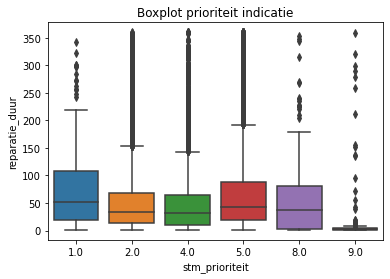

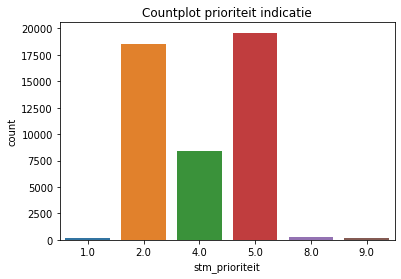

In [105]:
sns.boxplot(y='reparatie_duur', x='stm_prioriteit', data=dataset_m4)
plt.title('Boxplot prioriteit indicatie')
plt.show()
sns.countplot(x='stm_prioriteit', data=dataset_m4)
plt.title('Countplot prioriteit indicatie')
plt.show()

Er is tegen verwachting in geen verband te zien in de boxplots tussen de prioriteits indicatie en hoelang de reparatie duur is, echter valt wel op dat prioriteits indicatie van 9 lager verdeeld ligt. Maar hier zijn niet genoeg samples van om een verband te leggen.
De meest voorkomende prioriteits indicaties zijn 2, 4 en 5.
Deze staan voor: urgent, urgent met tijd afspraak en niet urgent met tijd afspraak.

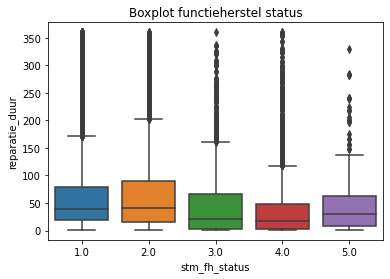

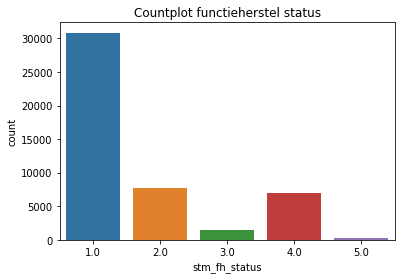

In [106]:
sns.boxplot(y='reparatie_duur', x='stm_fh_status', data=dataset_m4)
plt.title('Boxplot functieherstel status')
plt.show()
sns.countplot(x='stm_fh_status', data=dataset_m4)
plt.title('Countplot functieherstel status')
plt.show()

Ook is er bij de functieherstel status geen duidelijk verband te zien tussen reparatie duur en welke status de functieherstel heeft.
Een status van 1. (Volledig Functieherstel) en 5. (Geen functieherstel), lijken apart genoeg niet aanzienlijk te verschillen in reparatieduren.
Een functieherstel status van 1 komt het vaakst voor en 50% van de gevallen reparatie duren met status 1 vallen binnen 25+- en 80 minuten. Dit is vreemd aangezien status 1 in de data dictionary als uitleg heeft:
- "1.Volledig Functieherstel, alleen vermelden als er geen afwijkingenmeer zijn van de ontworpen functionaliteit van het infraobject en welhandelingen zijn verricht;"

#### Data preparation

##### NAN waardes controlers

In [107]:
dataset_m4[features].isna().sum()

stm_prioriteit      0
aanntpl_dagdeel     0
stm_techn_gst      21
contract_gebied    21
stm_fh_status       5
dtype: int64

Verhouding NAN waardes is laag genoeg om te droppen.

In [108]:
dataset_m4.dropna(subset=features, inplace=True)

##### Dtypes

Dtypes controleren

In [109]:
dataset_m4[features].dtypes

stm_prioriteit      float64
aanntpl_dagdeel    category
stm_techn_gst        object
contract_gebied      object
stm_fh_status       float64
dtype: object

Nog niet alle dtypes kloppen, alle gebruikte feature variabelen zijn categoriaal en worden van het type category gemaakt.

In [110]:
dataset_m4[features] = dataset_m4[features].astype('category')

#### Modeling model 4

Voor model 4 hebben we een classificatie algoritme nodig. Hiervoor gebruiken we ook een beslisboom omdat we nog niet precies weten welke variabelen veel invloed hebben en zoals eerder beschreven een beslisboom zelf de meest invloedrijke features gebruikt om een voorspelling te maken.

Eerst encoden we de categoriale features met get_dummies en maken we een train en test set.

In [111]:
X = pd.get_dummies(dataset_m4[features], drop_first=True)
y = dataset_m4['reparatie_duur_<=15']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Model maken en Hyper-parameter tuning

Om de optimale beslis boom te vinden, testen we de accuracy score van een beslis boom met dieptes 1 t/m 14.

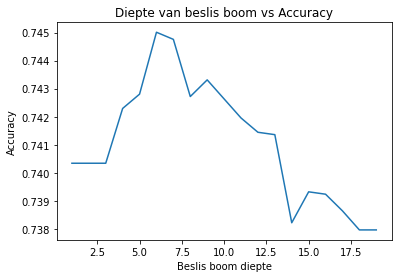

Accuracy: 0.737964, Accuracy is 0% lager in verhouding met de baseline


In [112]:
depths = np.arange(1, 20)
scores =  [round(accuracy_score(y_test,DecisionTreeClassifier(max_depth=d).fit(X_train,y_train).predict(X_test)),6) for d in depths]
acc_tree = min(scores)
plt.plot(depths, scores)
plt.xlabel("Beslis boom diepte")
plt.ylabel("Accuracy")
plt.title("Diepte van beslis boom vs Accuracy")
plt.show()
dict((zip(map(lambda x: f"diepte {x}", depths), scores)))
print(f"Accuracy: {acc_tree}, Accuracy is {100 - round(acc_tree/baseline_acc*100)}% lager in verhouding met de baseline")

#### Conclusie

Aan de hand van variabelen die bekend zijn voordat de aannemer een prognose heeft gedaan namelijk:
   - Prioriteit indicatie
   - Aannemer ter plaatse tijd
   - Techniekveld
   - Contractgebied aannemer
   - Functieherstel status

Is geen betere voorspelling te maken dan de baseline. Hieruit kunnen we concluderen dat deze genoemde variabelen niet genoeg voorspelkracht hebben om te classificeren of een reparatie korter of langer duur dan 15 minuten.
Vanuit deze bevinding is ondervonden dat het vroegste moment in het proces van een storing om een nuttige voorspelling te doen. Op het moment is wanneer de aannemer een prognose heeft gedaan, data beschikbaar voordat deze prognose is gedaan heeft weinig tot geen voorspelkracht.

### Eind conclusie

Alleen de prognose van de aannemer is in de huidige dataset van ProRail nuttige informatie om een voorspellend model te construeren.
Uit de modellen die alleen de prognose van de aannemer gebruiken adviseren wij het eenvoudige lineaire regressie model. Dit model heeft een 14% lagere RMSE dan de RMSE van de prognose, dit betekend dat ons model gemiddeld 14% minder afwijkt van de daadwerkelijke reparatieduur.
Ook hebben we aangetoond dat de prognoses pessimistisch zijn, ons lineair regressie model voorspelt dan ook kortere reparatie duren dan de prognose van de aannemer.